In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glasses.utils.PretrainedWeightsProvider import PretrainedWeightsProvider
from glasses.models import AutoModel
from torch import nn

class Dummy(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Conv2d(3, 32, kernel_size=3), 
                        nn.Conv2d(32, 64, kernel_size=3))

dummy = Dummy()
        
provider = PretrainedWeightsProvider()
# state_dict = provider['dummy']


In [14]:
AutoModel.models_table()

# Intepretability


INFO:root:Loaded resnet18 pretrained weights.


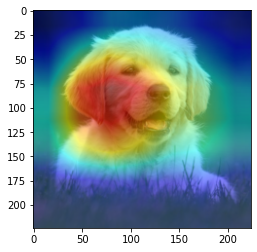

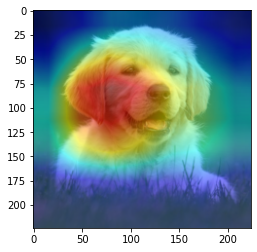

In [4]:
import requests
from PIL import Image
from io import BytesIO
from glasses.interpretability import GradCam, SaliencyMap, ScoreCam
from torchvision.transforms import Normalize
from glasses.models import AutoModel, AutoConfig

model = AutoModel.from_pretrained('resnet18').cuda()
cfg = AutoConfig.from_name('resnet18')
r = requests.get('https://i.insider.com/5df126b679d7570ad2044f3e?width=700&format=jpeg&auto=webp')
im = Image.open(BytesIO(r.content))
# un normalize when done
postprocessing = Normalize(-cfg.mean / cfg.std, (1.0 / cfg.std))
# # apply preprocessing
x =  cfg.transform(im).unsqueeze(0).cuda()
# _ = model.interpret(x, using=GradCam(), postprocessing=postprocessing).show()


ScoreCam()(x, model, postprocessing=postprocessing).show()

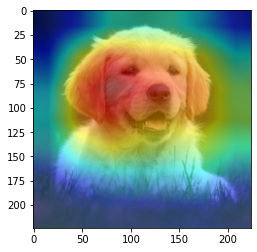

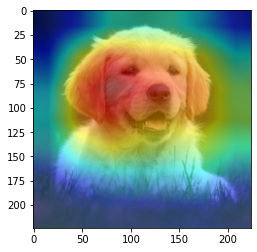

In [43]:
GradCam()(x, model, postprocessing=postprocessing).show()

In [41]:
from einops import rearrange
import torch
import torch.nn.functional as F
from

a = torch.rand((2, 10, 5, 5))

# rear = rearrange(a, 'b c h w -> b (c h w)',)

a = F.interpolate(a, size=(224, 224), mode='bilinear', align_corners=False)
# scaling
# rear.shape
mins = a.min(keepdim=True, dim=1).values
maxs = a.max(keepdim=True, dim=1).values
scaling = (a - mins) / (maxs - mins)
scaling

tensor([[[[0.8032, 0.8032, 0.8032,  ..., 0.0316, 0.0316, 0.0316],
          [0.8032, 0.8032, 0.8032,  ..., 0.0316, 0.0316, 0.0316],
          [0.8032, 0.8032, 0.8032,  ..., 0.0316, 0.0316, 0.0316],
          ...,
          [0.0354, 0.0354, 0.0354,  ..., 0.9403, 0.9403, 0.9403],
          [0.0354, 0.0354, 0.0354,  ..., 0.9403, 0.9403, 0.9403],
          [0.0354, 0.0354, 0.0354,  ..., 0.9403, 0.9403, 0.9403]],

         [[0.9359, 0.9359, 0.9359,  ..., 0.7071, 0.7071, 0.7071],
          [0.9359, 0.9359, 0.9359,  ..., 0.7071, 0.7071, 0.7071],
          [0.9359, 0.9359, 0.9359,  ..., 0.7071, 0.7071, 0.7071],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.2538, 0.2538, 0.2538],
          [1.0000, 1.0000, 1.0000,  ..., 0.2538, 0.2538, 0.2538],
          [1.0000, 1.0000, 1.0000,  ..., 0.2538, 0.2538, 0.2538]],

         [[0.2173, 0.2173, 0.2173,  ..., 0.7678, 0.7678, 0.7678],
          [0.2173, 0.2173, 0.2173,  ..., 0.7678, 0.7678, 0.7678],
          [0.2173, 0.2173, 0.2173,  ..., 0

# Benchmark

In [35]:
from glasses.models import AutoModel, AutoConfig
import torch

In [36]:
model = AutoModel.from_name('vit_base_patch16_224')
model

ViT(
  (embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
    (tokens): ViTTokens()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderBlock(
        (0): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (1): MultiHeadAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (att_drop): Dropout(p=0.0, inplace=False)
              (projection): Sequential(
                (0): Linear(in_features=768, out_features=768, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
        )
        (1): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (1): FeedForwardBlock(
              (0): 

In [38]:
from glasses.models.classification.deit import DeiT
DeiT().embedding.tokens.dist

Parameter containing:
tensor([[[-1.0900e+00,  5.9232e-01, -1.3475e+00, -8.8945e-03,  2.8032e-01,
          -2.5296e+00, -1.2493e+00,  1.9137e-01, -8.4429e-01, -3.9187e-01,
          -1.3274e-01,  1.9846e-01,  2.0594e-01,  3.8294e-01,  1.4616e+00,
           7.3132e-02, -2.6978e-02,  1.2118e-01, -7.7703e-01,  7.8420e-01,
          -1.9390e+00,  2.5998e+00,  1.5004e+00, -1.4453e+00, -1.0452e+00,
          -3.9081e-01,  6.5189e-02, -6.0795e-01, -6.4043e-01, -1.3401e+00,
           5.5202e-01, -6.9359e-01,  1.5587e+00,  6.1924e-01, -4.4311e-02,
           1.2512e+00,  8.5140e-01,  2.0568e+00,  2.7636e-01,  4.0293e-01,
           1.1603e+00,  1.2421e+00,  2.1889e-01, -2.3521e-01, -6.4439e-01,
           9.5910e-01,  1.3049e+00,  2.0507e+00, -1.1315e-01,  1.2872e+00,
           4.0509e-02, -1.9550e-01,  3.4365e-01, -3.1178e-01, -1.2283e+00,
          -3.5690e-02,  5.9273e-02,  8.8650e-01,  8.9549e-01, -5.8535e-01,
           6.3476e-01, -7.6959e-01,  4.5018e-01, -6.3732e-01, -5.4927e-01,
   

In [39]:
import torch
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_distilled_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /home/zuppif/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_224-df68dfff.pth" to /home/zuppif/.cache/torch/hub/checkpoints/deit_base_distilled_patch16_224-df68dfff.pth


  0%|          | 0.00/333M [00:00<?, ?B/s]

In [11]:
model

DistilledVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(


# Clone

In [14]:
import torch
from glasses.models import AutoModel, AutoConfig, EfficientNetLite
import timm
from transfer_weights import clone_model, deit_clone
from benchmark import benchmark
from glasses.models.classification.vit import ViTTokens

src = torch.hub.load('facebookresearch/deit:main', 'deit_small_distilled_patch16_224', pretrained=True).eval()
dst = deit_clone('deit_small_patch16_224').eval()
# src = timm.create_model('vit_base_patch16_224', pretrained='True')
# dst = AutoModel.from_name('vit_base_patch16_224')
transform = AutoConfig.from_name('vit_base_patch16_224').transform

Using cache found in /home/zuppif/.cache/torch/hub/facebookresearch_deit_main
Using cache found in /home/zuppif/.cache/torch/hub/facebookresearch_deit_main


In [7]:
benchmark(dst.cuda(), transform, 256)

Using downloaded and verified file: ./imagenet_val_targets.pkl


  0%|          | 0/196 [00:00<?, ?it/s]


100%|██████████| 50000/50000 [00:05<00:00, 8977.28it/s]


(0.80258, 0.9512, 113.77364897727966)

In [15]:
benchmark(src.cuda(), transform, 256)

Using downloaded and verified file: ./imagenet_val_targets.pkl


  0%|          | 0/196 [00:00<?, ?it/s]


100%|██████████| 50000/50000 [00:05<00:00, 9045.41it/s]
/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


(0.80258, 0.9512, 117.3070387840271)

In [12]:
dst.summary()

Layer (type:depth-idx)                        Output Shape              Param #
├─PatchEmbedding: 1-1                         [1, 198, 384]             --
|    └─Sequential: 2-1                        [1, 196, 384]             --
|    |    └─Conv2d: 3-1                       [1, 384, 14, 14]          295,296
|    |    └─Rearrange: 3-2                    [1, 196, 384]             --
|    └─DeiTTokens: 2-2                        [1, 1, 384]               768
├─TransformerEncoder: 1-2                     [1, 198, 384]             --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderBlock: 3-3      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-4      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-5      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-6      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-7      [1, 198, 384]  

Layer (type:depth-idx)                        Output Shape              Param #
├─PatchEmbedding: 1-1                         [1, 198, 384]             --
|    └─Sequential: 2-1                        [1, 196, 384]             --
|    |    └─Conv2d: 3-1                       [1, 384, 14, 14]          295,296
|    |    └─Rearrange: 3-2                    [1, 196, 384]             --
|    └─DeiTTokens: 2-2                        [1, 1, 384]               768
├─TransformerEncoder: 1-2                     [1, 198, 384]             --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderBlock: 3-3      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-4      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-5      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-6      [1, 198, 384]             1,774,464
|    |    └─TransformerEncoderBlock: 3-7      [1, 198, 384]  